In [1]:
# instruction to run: simply run all blocks, a prediction csv will be downloaded at the end : )

In [2]:
%%capture

import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install transformers

In [3]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import random
from sklearn.preprocessing import StandardScaler
from torchvision import models
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from google.colab import files
from transformers import AutoImageProcessor, AutoModel, AutoFeatureExtractor
import torch.hub
import xgboost as xgb

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%%capture
! unzip -o /content/drive/MyDrive/data.zip

In [7]:
# load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [8]:
# Normalize train data

# Identify the columns
id_column = train_df.columns[0]
target_columns = train_df.columns[-6:]
ancillary_columns = train_df.columns[1:-6]  # Excluding id and target columns

In [9]:
# Separate the features and the target columns
X_train_ancillary = train_df[ancillary_columns]
y_train = train_df[target_columns]

In [10]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_ancillary = pd.DataFrame(scaler_X.fit_transform(X_train_ancillary), columns=ancillary_columns)
y_train = pd.DataFrame(scaler_y.fit_transform(y_train), columns=target_columns)

In [11]:
train_df = pd.concat([train_df[[id_column]], X_train_ancillary, y_train], axis=1)

In [12]:
# Normalize test data

# Identify the columns
test_id_column = test_df.columns[0]
test_ancillary_columns = test_df.columns[1:]

X_test_ancillary = test_df[test_ancillary_columns]

X_test_ancillary = pd.DataFrame(scaler_X.transform(X_test_ancillary), columns=test_ancillary_columns)

test_df = pd.concat([test_df[[test_id_column]], X_test_ancillary], axis=1)

In [13]:
# Convert ancillary data to float32
X_train_ancillary = X_train_ancillary.to_numpy(dtype='float32')
X_test_ancillary = X_test_ancillary.to_numpy(dtype='float32')
y_train = y_train.to_numpy(dtype='float32')

In [25]:
class PlantDataset(Dataset):
    def __init__(self, dataframe, ancillary_data, transform, directory, labels=None):
        self.dataframe = dataframe
        self.ancillary_data = ancillary_data
        self.labels = labels
        self.transform = transform
        self.directory = directory

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.directory, f"{img_id}.jpeg")
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        ancillary = self.ancillary_data[idx]
        if self.labels is not None:
            label = self.labels[idx]
            return image, ancillary, label, img_id
        return image, ancillary, img_id

In [26]:
# Image data transformations
image_transform = transforms.Compose(
    [
        transforms.Resize(
            (224, 224)
        ),
        transforms.ToTensor()
    ]
)

In [28]:
# Dataset and DataLoader
train_dataset_full = PlantDataset(train_df, X_train_ancillary, image_transform, 'data/train_images/', y_train)
train_loader_full = DataLoader(train_dataset_full, batch_size=100, shuffle=True)

test_dataset_full = PlantDataset(test_df, X_test_ancillary, image_transform, 'data/test_images/')
test_loader_full = DataLoader(test_dataset_full, batch_size=100, shuffle=False)

In [29]:
# Split the data into 90% training and 10% testing

seed = 777
train_indices, test_indices = train_test_split(np.arange(len(train_loader_full.dataset)), test_size=0.1, random_state=10)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(train_loader_full.dataset, batch_size=train_loader_full.batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(train_loader_full.dataset, batch_size=train_loader_full.batch_size, sampler=test_sampler)

In [30]:
def extract_image_features(loader, device):
    model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14_reg_lc")
    model = model.to(device)
    model.eval()

    all_features = []
    all_labels = []
    all_ancillary = []

    with torch.no_grad():
        for images, ancillary, labels, __ in loader:
            images = images.to(device)
            ancillary = ancillary.to(device)
            labels = labels.to(device)

            # Extract features using transformer model
            with torch.no_grad():
                features = model(images).squeeze().cpu().numpy()

            all_features.append(features)
            all_ancillary.append(ancillary.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_features = np.vstack(all_features)
    all_ancillary = np.vstack(all_ancillary)
    all_labels = np.vstack(all_labels)

    return all_features, all_ancillary,all_labels


In [31]:
# Extract features for train and test datasets
train_image_features,train_ancillary, train_labels = extract_image_features(train_loader, device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [32]:
test_image_features,test_ancillary, test_labels = extract_image_features(test_loader, device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [33]:
# For plotting errors
class LogRMSECallback(xgb.callback.TrainingCallback):
    def __init__(self):
        self.train_rmse = []
        self.eval_rmse = []

    def after_iteration(self, model, epoch, evals_log):
        self.train_rmse.append(evals_log['train']['rmse'][-1])
        self.eval_rmse.append(evals_log['eval']['rmse'][-1])
        return False

rmse_callback = LogRMSECallback()

[0]	train-rmse:0.99669	eval-rmse:1.00105
[1]	train-rmse:0.99381	eval-rmse:0.99859
[2]	train-rmse:0.99098	eval-rmse:0.99614
[3]	train-rmse:0.98819	eval-rmse:0.99374
[4]	train-rmse:0.98543	eval-rmse:0.99136
[5]	train-rmse:0.98271	eval-rmse:0.98907
[6]	train-rmse:0.98002	eval-rmse:0.98682
[7]	train-rmse:0.97737	eval-rmse:0.98459
[8]	train-rmse:0.97475	eval-rmse:0.98237
[9]	train-rmse:0.97214	eval-rmse:0.98020
[10]	train-rmse:0.96959	eval-rmse:0.97804
[11]	train-rmse:0.96705	eval-rmse:0.97593
[12]	train-rmse:0.96455	eval-rmse:0.97383
[13]	train-rmse:0.96208	eval-rmse:0.97174
[14]	train-rmse:0.95965	eval-rmse:0.96966
[15]	train-rmse:0.95722	eval-rmse:0.96760
[16]	train-rmse:0.95484	eval-rmse:0.96565
[17]	train-rmse:0.95246	eval-rmse:0.96369
[18]	train-rmse:0.95011	eval-rmse:0.96174
[19]	train-rmse:0.94779	eval-rmse:0.95983
[20]	train-rmse:0.94551	eval-rmse:0.95795
[21]	train-rmse:0.94326	eval-rmse:0.95609
[22]	train-rmse:0.94101	eval-rmse:0.95423
[23]	train-rmse:0.93881	eval-rmse:0.95240
[2

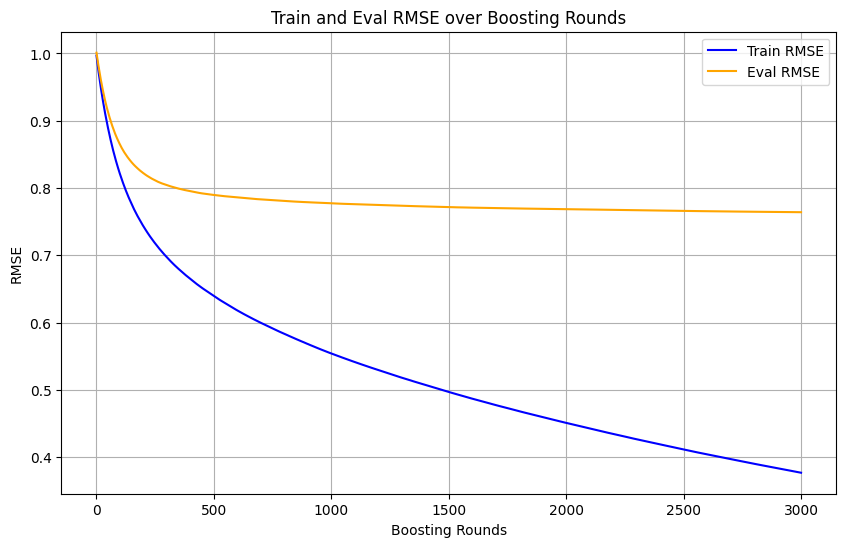

R² score on the validation set for seed = 777: 0.4221


In [34]:
dtrain = xgb.DMatrix(np.hstack([train_image_features, train_ancillary]), label=train_labels)

dval = xgb.DMatrix(np.hstack([test_image_features, test_ancillary]), label=test_labels)

for i in range(1):
  random.seed(seed)
  params = {
      'objective': 'reg:squarederror',
      'eval_metric': 'rmse',
      'eta': 0.01,
      'max_depth': 6,
      'device':'gpu'
  }
  early_stopping_rounds = 50

  watchlist = [(dtrain, 'train'), (dval, 'eval')]

  xgb_model = xgb.train(params, dtrain, num_boost_round=3000, evals=watchlist,
                        early_stopping_rounds=early_stopping_rounds, callbacks=[rmse_callback])

  boosting_rounds = range(1, len(rmse_callback.train_rmse) + 1)
  plt.figure(figsize=(10, 6))
  plt.plot(boosting_rounds, rmse_callback.train_rmse, label='Train RMSE', color='blue')
  plt.plot(boosting_rounds, rmse_callback.eval_rmse, label='Eval RMSE', color='orange')
  plt.xlabel('Boosting Rounds')
  plt.ylabel('RMSE')
  plt.title('Train and Eval RMSE over Boosting Rounds')
  plt.legend()
  plt.grid(True)
  plt.show()

   # Predict on validation set
  val_predictions = xgb_model.predict(dval)

  # Calculate R2 score
  r2_val = r2_score(test_labels, val_predictions)
  print(f"R² score on the validation set for seed = {seed}: {r2_val:.4f}")




In [35]:
def extract_image_features_test(loader, device):
    model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14_reg_lc")
    model = model.to(device)
    model.eval()

    # Store extracted features and labels
    all_features = []
    all_ancillary = []

    with torch.no_grad():
        for images, ancillary, __ in loader:
            images = images.to(device)
            ancillary = ancillary.to(device)
            with torch.no_grad():
                features = model(images).squeeze().cpu().numpy()
            all_features.append(features)
            all_ancillary.append(ancillary.cpu().numpy())

    all_features = np.vstack(all_features)
    all_ancillary = np.vstack(all_ancillary)

    return all_features, all_ancillary


In [36]:
testing_image_features, testing_ancillary = extract_image_features_test(test_loader_full, device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [37]:
# Make predictions
dtest = xgb.DMatrix(np.hstack([testing_image_features, testing_ancillary]))
predictions = xgb_model.predict(dtest)

In [38]:
# Inverse transform the predicted values
predictions = scaler_y.inverse_transform(predictions.reshape(-1, 6))

In [39]:
test_ids = test_df['id'].tolist()

In [40]:
predictions_df = pd.DataFrame(predictions, columns=['X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
predictions_df.insert(0, 'id', test_ids)  # Insert id column

predictions_df.to_csv('predictions_submission.csv', index=False)
files.download("predictions_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>